# fraud_demo.ipynb – A runnable Demo Notebook

### A Demo notebook that doesn't break your CPU
Avoids CPU overload by loading cached KNN predictions instead of recomputing them on the full dataset.

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve()
src_dir = project_root / "src"

sys.path.append(str(project_root))
sys.path.append(str(src_dir))

import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Suppress only InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

import os
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

from src.models.knn import KNNModel
from src.models.lda import LDAModel
from src.models.linreg import LinearRegressionModel
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score,
    precision_score, f1_score, roc_curve, auc
)

from src import ARTIFACTS_DIR, PROC_DIR

In [2]:
X_test = pd.read_csv(Path(PROC_DIR, "X_test.csv")).values

In [3]:
knn_pred_path = Path(ARTIFACTS_DIR, "knn_pred.npy")

if knn_pred_path.exists():
    knn_pred = np.load(knn_pred_path)
    print("[demo] Loaded cached KNN predictions.")
else:
    print("[demo] Running KNN prediction...")
    with open(Path(ARTIFACTS_DIR, "knn.pkl"), "rb") as f:
        knn_model = pickle.load(f)
    knn_pred = knn_model.predict(X_test)
    np.save(knn_pred_path, knn_pred)
    print("[demo] KNN predictions saved.")

[demo] Loaded cached KNN predictions.


In [4]:
with open(Path(ARTIFACTS_DIR, "lda.pkl"), "rb") as f:
    lda_model = pickle.load(f)

with open(Path(ARTIFACTS_DIR, "lr.pkl"), "rb") as f:
    lr_model = pickle.load(f)

lda_pred = lda_model.predict(X_test)
lr_score = lr_model.predict(X_test)  # Continuous score

In [5]:
lr_mean = lr_score.mean()
ensemble_pred = knn_pred.copy()

for i in range(len(knn_pred)):
    if knn_pred[i] == 0 or lda_pred[i] == 0:
        if lr_score[i] < lr_mean:
            ensemble_pred[i] = 0
    elif knn_pred[i] == 1 or lda_pred[i] == 1:
        if lr_score[i] > lr_mean:
            ensemble_pred[i] = 1

In [6]:
y_true_path = Path(ARTIFACTS_DIR, "y_true.npy")
if not y_true_path.exists():
    print("[demo] Ground truth labels not found. Skipping evaluation.")
else:
    y_true = np.load(y_true_path)

    cm = confusion_matrix(y_true, ensemble_pred, labels=[0, 1])

    fpr, tpr, _ = roc_curve(y_true, ensemble_pred, pos_label=0)
    roc_auc = auc(fpr, tpr)
    recall = float(recall_score(y_true, ensemble_pred, pos_label=0))
    accuracy = float(accuracy_score(y_true, ensemble_pred))
    f1 = float(f1_score(y_true, ensemble_pred, pos_label=0))

    print("\n--- Evaluation Metrics ---")
    print(f"Recall   : {recall:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)


--- Evaluation Metrics ---
Recall   : 1.0000
Accuracy : 0.9992
F1 Score : 0.9996
ROC AUC  : 0.3135

Confusion Matrix:
[[1270866      15]
 [   1030     613]]


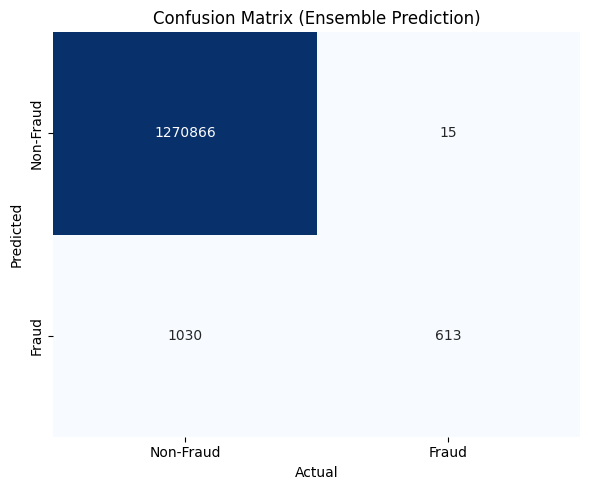

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix as DataFrame
cm_labels = ['Non-Fraud', 'Fraud']
cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Ensemble Prediction)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()